In [7]:
import cv2
import pytesseract
import re
import matplotlib.pyplot as plt

#if TesseractNotFoundError occurs
pytesseract.pytesseract.tesseract_cmd = r'C:\Users\ammar.jamalludin\AppData\Local\Programs\Tesseract-OCR\tesseract.exe'

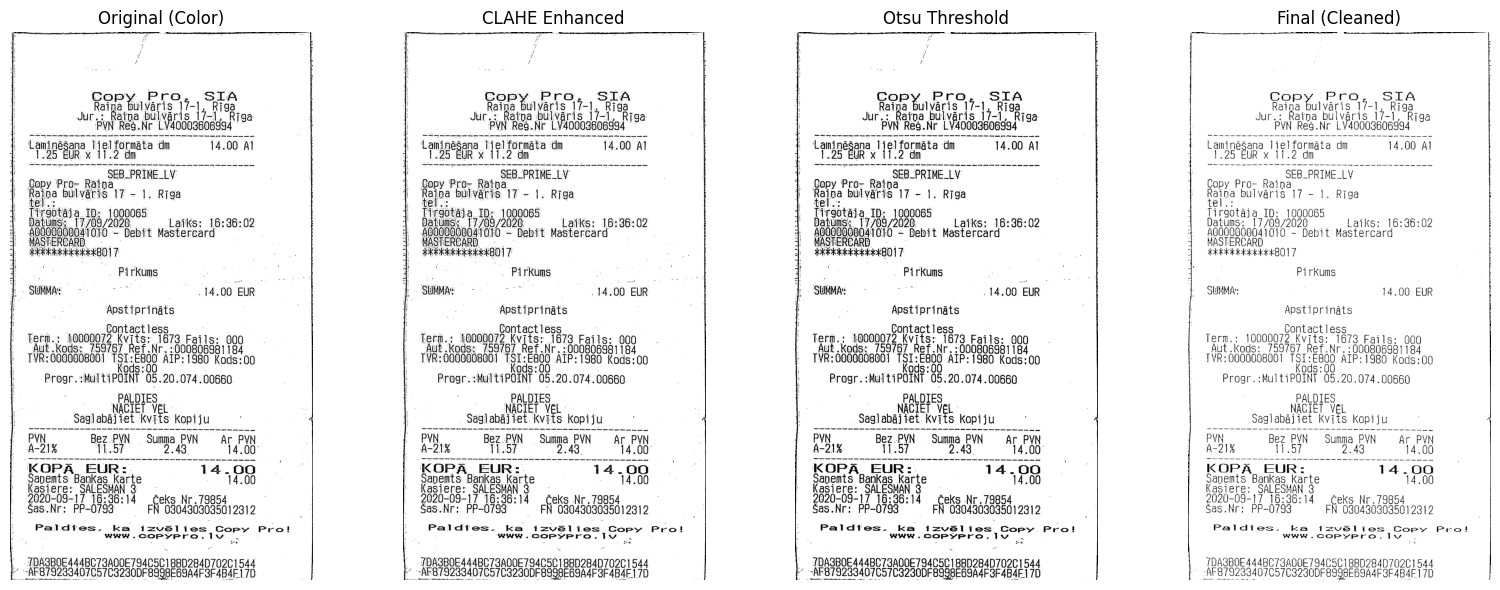

In [20]:
image_path = "result.png"
image = cv2.imread(image_path)
image = cv2.resize(image, None, fx=1.2, fy=1.2, interpolation=cv2.INTER_CUBIC)

# Keep original color copy for display
image_color = image.copy()

# --- Convert to gray and denoise ---
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# Non-local means denoising (works well for text images)
denoised = cv2.fastNlMeansDenoising(gray, h=10)

# --- Contrast enhancement (CLAHE) ---
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
enhanced = clahe.apply(denoised)

# --- Thresholding (Otsu + adaptive as alternatives) ---
blur = cv2.GaussianBlur(enhanced, (5, 5), 0)
otsu = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
adaptive = cv2.adaptiveThreshold(enhanced, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                 cv2.THRESH_BINARY, 11, 2)

# Ensure text is dark on light background (pytesseract prefers this)
white_ratio = (otsu == 255).mean()
if white_ratio < 0.5:
    otsu = cv2.bitwise_not(otsu)

# --- Morphological clean-up ---
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
clean = cv2.morphologyEx(otsu, cv2.MORPH_OPEN, kernel, iterations=1)
clean = cv2.morphologyEx(clean, cv2.MORPH_CLOSE, kernel, iterations=1)
# Slight dilation to strengthen characters
clean = cv2.dilate(clean, kernel, iterations=1)

final = clean

# Show intermediate and final results side-by-side
fig, axes = plt.subplots(1, 4, figsize=(16, 6))
axes[0].imshow(cv2.cvtColor(image_color, cv2.COLOR_BGR2RGB))
axes[0].set_title('Original (Color)')
axes[0].axis('off')

axes[1].imshow(enhanced, cmap='gray')
axes[1].set_title('CLAHE Enhanced')
axes[1].axis('off')

axes[2].imshow(otsu, cmap='gray')
axes[2].set_title('Otsu Threshold')
axes[2].axis('off')

axes[3].imshow(final, cmap='gray')
axes[3].set_title('Final (Cleaned)')
axes[3].axis('off')

plt.tight_layout()
plt.show()

# Prepare final image for OCR
final_rgb = cv2.cvtColor(final, cv2.COLOR_GRAY2RGB)


In [21]:
# OCR on the cleaned image
textConverted = pytesseract.image_to_string(final_rgb, config='--psm 6')
textConverted = re.sub(r'[^\x00-\x7F]+|\x0c', ' ', textConverted)

print(textConverted)


Copy Pro SLA ,
| Raina bulvaris 17-1, Riga
Jur.: Raina bul vars 17-1, Riga
: PVN Reg.Nr LY40003606994
- Lamin Sana Jielformata dm 14.00 Al
, 1.25 BOR xX 11.2 dm
i _ SEB_PRIME_LY |
| Copy Pro- Raina :
1 Raina bulvaris 17 - |. Riga
tel.: :
  Tirgotaja_ ID: 1000065 ;
}  Datums: 17/09/2020 - Laiks: 16:36:02
7  AQ000000041010 - Debit Mastercard
~ MASTERCARD _
i AKKEKAKAKAAKBO | 7
fo Pirkums oe a
| SUMMA: a 14.00 EUR
\ Apstiprinats
| Contactless
Term.: 10000072 Av its: 1673 Fails: 000
Aut.kKods: 759767 Ref.Nr.:000806981184
- JYR:0000008001 Preaat AIP: 1980 Kods:00
| ods:
: Progr.:MultiPOINT 05.20.074.00660
: PALDIES
| NACIET VEE
| saglabajiet Kvits Kopiju :
PYN Bez PYN Summa PYN Ar PYN
A-21% 11.57 2.43 14.00
KOPA_ EUR: 14.00
sanemts Bankas Karte 14.00
Kasiere: SALESMAN 3
2020-09-17 16:36:14 Geks Nr.79854
Sas .Nr: PP-0793 FN 0304303038501 2312 .
Paldities. ka itizv lies Copy Pro!
. WWW. COPYPro. Tv
/DA3BOE444BC73A00E794C05C 1 8BD284D070201544
~ ~AFB7923340705/7C3230DF B998E69A4F 3F 4B4F 1 7D
